# Telecom Churn - ML Group Case Study

# Objective: To reduce customer churn, need to predict which customers are at high risk of churn.

Analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

Churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Pepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

## Definitions of Churn
Revenue-based churn: Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. One could also use aggregate metrics such as ‘customers who have generated less than INR 4 per month in total/average/median revenue’.

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

Use the usage-based definition to define churn.

## High-value Churn
In indian/SE market, approximately 80% of revenue comes from top 20% high-value customers. Churn reduction of high-value customers will reduce significant revenue leakage.
 
Define high-value customers based on a certain metric and predict churn only on high-value customers.

## Understanding the Business Objective and the Data
Dataset contains customer information for 4 consecutive months - June:6, July:7, August:8 and September:9. 

Business objective is to predict churn in the last (i.e. the ninth) month using the data (features) from first 3 months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn

Customers switch to another competitor over a period of time (especially applicable to high-value customers). We assume that there are three phases of customer lifecycle :

    ‘good’ phase: Customer is happy.
    ‘action’ phase: Customer experience deteriorates. Customer shows different behaviour than good’ months. Crucial to identify high-churn-risk customers in this phase since corrective actions can be taken at this point.
    ‘churn’ phase: Customer has churned. Define churn based on this phase. At the time of prediction (i.e. the action months), this data is not available for prediction. After tagging churn as 1/0 based on this phase, discard all data corresponding to this phase.

Over the four-month window, first 2 months are ‘good’ phase, 3rd month is ‘action’ phase, while 4th month is ‘churn’ phase.

## Data Preparation

The following data preparation steps are crucial for this problem:

1. Derive new features - Use business understanding to derive features that can be important indicators of churn.

2. Filter high-value customers - Predict churn only for high-value customers. High-value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

After filtering the high-value customers, expect about 29.9k rows.

3. Tag churners and remove attributes of the churn phase - Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes to tag churners are:

    total_ic_mou_9
    
    total_og_mou_9
    
    vol_2g_mb_9
    
    vol_3g_mb_9

After tagging churners, remove all attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

## Modelling

Build models to predict churn. The predictive model will serve two purposes:

    Predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take corrective actions.
    Identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

We have a large number of attributes and thus we should try using a dimensionality reduction technique such as PCA and then build a predictive model. After PCA, use any classification model.
 
Since the rate of churn is typically low (about 5-10%, this is called class-imbalance) - try using techniques to handle class imbalance.

Take following suggestive steps to build the model:

    Preprocess data (convert columns to appropriate formats, handle missing values, etc.)

    Conduct appropriate EDA to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

    Derive new features.

    Reduce the number of variables using PCA.

    Train a variety of models, tune model hyperparameters, etc. (handle class imbalance using appropriate techniques).

    Evaluate models using appropriate evaluation metrics. More important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

    Finally, choose a model based on some evaluation metric.

The above model will only be able to achieve one of the two goals - to predict customers who will churn. Above model cannot identify the important features for churn. That’s because PCA usually creates components which are not easy to interpret.

Therefore, build another model with the main objective of identifying important predictor attributes which help the business understand indicators of churn. A good choice to identify important variables is a logistic regression model or a model from the tree family. In case of logistic regression, make sure to handle multi-collinearity.

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

Finally, recommend strategies to manage customer churn based on your observations.

# Understand Data

In [192]:
# import functions from libraries that is used in the solution
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#Load the data from CSV file
telecom = pd.read_csv("telecom_churn_data.csv", encoding = "ISO-8859-1")
print(telecom.shape)

(99999, 226)


## We see there are 226 columns and 99999 rows in the dataframe

In [193]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Data Preparation

In [194]:
# Drop irrelevant fields - either not relevant or all zeros
telecom = telecom.drop(['circle_id'], axis=1)

telecom = telecom.drop(['loc_og_t2o_mou'], axis=1)
telecom = telecom.drop(['std_og_t2o_mou'], axis=1)
telecom = telecom.drop(['loc_ic_t2o_mou'], axis=1)

telecom = telecom.drop(['std_og_t2c_mou_6'], axis=1)
telecom = telecom.drop(['std_og_t2c_mou_7'], axis=1)
telecom = telecom.drop(['std_og_t2c_mou_8'], axis=1)
telecom = telecom.drop(['std_og_t2c_mou_9'], axis=1)

telecom = telecom.drop(['std_ic_t2o_mou_6'], axis=1)
telecom = telecom.drop(['std_ic_t2o_mou_7'], axis=1)
telecom = telecom.drop(['std_ic_t2o_mou_8'], axis=1)
telecom = telecom.drop(['std_ic_t2o_mou_9'], axis=1)

telecom = telecom[telecom.columns.drop(list(telecom.filter(regex='_vbc_')))]
telecom = telecom[telecom.columns.drop(list(telecom.filter(regex='last_date_of_month_')))]
telecom = telecom[telecom.columns.drop(list(telecom.filter(regex='arpu_')))]
#telecom = telecom[telecom.columns.drop(list(telecom.filter(regex='vol_')))]

In [195]:
# Add some derived features to identify high value customers
telecom['tot_recharge_6_7'] = round((telecom['total_rech_amt_6'] + telecom['total_rech_amt_7'])/2)

telecom['onnet_mou_change'] = \
 np.mean((telecom['onnet_mou_6'], telecom['onnet_mou_7']),axis=0) - telecom['onnet_mou_8']
telecom['loc_og_mou_change'] = \
 np.mean((telecom['loc_og_mou_6'], telecom['loc_og_mou_7']),axis=0) - telecom['loc_og_mou_8']
telecom['std_og_t2t_mou_change'] = \
 np.mean((telecom['std_og_t2t_mou_6'], telecom['std_og_t2t_mou_7']),axis=0) - telecom['std_og_t2t_mou_8']
telecom['loc_ic_mou_change'] = \
 np.mean((telecom['loc_ic_mou_6'], telecom['loc_ic_mou_7']),axis=0) - telecom['loc_ic_mou_8']

In [196]:
# Check % of null values for all columns
print((round(100*(telecom.isnull().sum()/len(telecom.index)),2)))

mobile_number             0.00
onnet_mou_6               3.94
onnet_mou_7               3.86
onnet_mou_8               5.38
onnet_mou_9               7.75
offnet_mou_6              3.94
offnet_mou_7              3.86
offnet_mou_8              5.38
offnet_mou_9              7.75
roam_ic_mou_6             3.94
roam_ic_mou_7             3.86
roam_ic_mou_8             5.38
roam_ic_mou_9             7.75
roam_og_mou_6             3.94
roam_og_mou_7             3.86
roam_og_mou_8             5.38
roam_og_mou_9             7.75
loc_og_t2t_mou_6          3.94
loc_og_t2t_mou_7          3.86
loc_og_t2t_mou_8          5.38
loc_og_t2t_mou_9          7.75
loc_og_t2m_mou_6          3.94
loc_og_t2m_mou_7          3.86
loc_og_t2m_mou_8          5.38
loc_og_t2m_mou_9          7.75
loc_og_t2f_mou_6          3.94
loc_og_t2f_mou_7          3.86
loc_og_t2f_mou_8          5.38
loc_og_t2f_mou_9          7.75
loc_og_t2c_mou_6          3.94
                         ...  
night_pck_user_6         74.85
night_pc

In [197]:
# Calculate percentage of NaN values in DataFrame and only include columns that contain any NaN values
def get_percentage_missing(series):
    num = series.isnull().sum()
    den = len(series)
    return round(100*(num/den), 2)

df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)

onnet_mou_6               3.94
onnet_mou_7               3.86
onnet_mou_8               5.38
onnet_mou_9               7.75
offnet_mou_6              3.94
offnet_mou_7              3.86
offnet_mou_8              5.38
offnet_mou_9              7.75
roam_ic_mou_6             3.94
roam_ic_mou_7             3.86
roam_ic_mou_8             5.38
roam_ic_mou_9             7.75
roam_og_mou_6             3.94
roam_og_mou_7             3.86
roam_og_mou_8             5.38
roam_og_mou_9             7.75
loc_og_t2t_mou_6          3.94
loc_og_t2t_mou_7          3.86
loc_og_t2t_mou_8          5.38
loc_og_t2t_mou_9          7.75
loc_og_t2m_mou_6          3.94
loc_og_t2m_mou_7          3.86
loc_og_t2m_mou_8          5.38
loc_og_t2m_mou_9          7.75
loc_og_t2f_mou_6          3.94
loc_og_t2f_mou_7          3.86
loc_og_t2f_mou_8          5.38
loc_og_t2f_mou_9          7.75
loc_og_t2c_mou_6          3.94
loc_og_t2c_mou_7          3.86
                         ...  
total_rech_data_8        73.66
total_re

In [198]:
# Fill NaN values in important columns with either 0 or -1 as they are numerical columns with depedency
# on other referenced columns. Treating columns that have more than 70% missing values

telecom['total_rech_data_6'].fillna(0, inplace=True)
telecom['total_rech_data_7'].fillna(0, inplace=True)
telecom['total_rech_data_8'].fillna(0, inplace=True)
telecom['total_rech_data_9'].fillna(0, inplace=True)
telecom['av_rech_amt_data_6'].fillna(0, inplace=True)
telecom['av_rech_amt_data_7'].fillna(0, inplace=True)
telecom['av_rech_amt_data_8'].fillna(0, inplace=True)
telecom['av_rech_amt_data_9'].fillna(0, inplace=True)
telecom['max_rech_data_6'].fillna(0, inplace=True)
telecom['max_rech_data_7'].fillna(0, inplace=True)
telecom['max_rech_data_8'].fillna(0, inplace=True)
telecom['max_rech_data_9'].fillna(0, inplace=True)
telecom['count_rech_2g_6'].fillna(0, inplace=True)
telecom['count_rech_2g_7'].fillna(0, inplace=True)
telecom['count_rech_2g_8'].fillna(0, inplace=True)
telecom['count_rech_2g_9'].fillna(0, inplace=True)
telecom['count_rech_3g_6'].fillna(0, inplace=True)
telecom['count_rech_3g_7'].fillna(0, inplace=True)
telecom['count_rech_3g_8'].fillna(0, inplace=True)
telecom['count_rech_3g_9'].fillna(0, inplace=True)
telecom['night_pck_user_6'].fillna(-1, inplace=True)
telecom['night_pck_user_7'].fillna(-1, inplace=True)
telecom['night_pck_user_8'].fillna(-1, inplace=True)
telecom['night_pck_user_9'].fillna(-1, inplace=True)
telecom['fb_user_6'].fillna(-1, inplace=True)
telecom['fb_user_7'].fillna(-1, inplace=True)
telecom['fb_user_8'].fillna(-1, inplace=True)
telecom['fb_user_9'].fillna(-1, inplace=True)

In [199]:
# Filling missing values in date fields using forward fill in panda dataframe 
telecom['date_of_last_rech_data_6'].fillna(0, inplace=True)
telecom['date_of_last_rech_data_7'].fillna(0, inplace=True)
telecom['date_of_last_rech_data_8'].fillna(0, inplace=True)
telecom['date_of_last_rech_data_9'].fillna(0, inplace=True)
telecom['date_of_last_rech_data_6'] = np.where(telecom['date_of_last_rech_data_6'] != 0, 1, 0)
telecom['date_of_last_rech_data_7'] = np.where(telecom['date_of_last_rech_data_7'] != 0, 1, 0)
telecom['date_of_last_rech_data_8'] = np.where(telecom['date_of_last_rech_data_8'] != 0, 1, 0)
telecom['date_of_last_rech_data_9'] = np.where(telecom['date_of_last_rech_data_9'] != 0, 1, 0)

telecom['date_of_last_rech_6'].fillna(0, inplace=True)
telecom['date_of_last_rech_7'].fillna(0, inplace=True)
telecom['date_of_last_rech_8'].fillna(0, inplace=True)
telecom['date_of_last_rech_9'].fillna(0, inplace=True)
telecom['date_of_last_rech_6'] = np.where(telecom['date_of_last_rech_6'] != 0, 1, 0)
telecom['date_of_last_rech_7'] = np.where(telecom['date_of_last_rech_7'] != 0, 1, 0)
telecom['date_of_last_rech_8'] = np.where(telecom['date_of_last_rech_8'] != 0, 1, 0)
telecom['date_of_last_rech_9'] = np.where(telecom['date_of_last_rech_9'] != 0, 1, 0)

In [200]:
# Checking NaN values again by only including columns that contain any NaN values
df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)

onnet_mou_6              3.94
onnet_mou_7              3.86
onnet_mou_8              5.38
onnet_mou_9              7.75
offnet_mou_6             3.94
offnet_mou_7             3.86
offnet_mou_8             5.38
offnet_mou_9             7.75
roam_ic_mou_6            3.94
roam_ic_mou_7            3.86
roam_ic_mou_8            5.38
roam_ic_mou_9            7.75
roam_og_mou_6            3.94
roam_og_mou_7            3.86
roam_og_mou_8            5.38
roam_og_mou_9            7.75
loc_og_t2t_mou_6         3.94
loc_og_t2t_mou_7         3.86
loc_og_t2t_mou_8         5.38
loc_og_t2t_mou_9         7.75
loc_og_t2m_mou_6         3.94
loc_og_t2m_mou_7         3.86
loc_og_t2m_mou_8         5.38
loc_og_t2m_mou_9         7.75
loc_og_t2f_mou_6         3.94
loc_og_t2f_mou_7         3.86
loc_og_t2f_mou_8         5.38
loc_og_t2f_mou_9         7.75
loc_og_t2c_mou_6         3.94
loc_og_t2c_mou_7         3.86
                         ... 
std_ic_t2t_mou_8         5.38
std_ic_t2t_mou_9         7.75
std_ic_t2m

In [201]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 199 entries, mobile_number to loc_ic_mou_change
dtypes: float64(157), int32(8), int64(34)
memory usage: 148.8 MB


## Most columns still have NaN values but the % has reduced significantly. Treat this later but for now lets check the NaN's in rows.

In [202]:
# Check the maximum number of NaN's in rows
telecom.isnull().sum(axis=1).max()

112

In [203]:
# Lets check how many rows have 50% of the data missing based on total number of columns
#telecom.apply(lambda x: x.count(), axis=1)
len(telecom[telecom.isnull().sum(axis=1) > 100].index)

1018

## 1018 rows are missing 50% of the data. Eliminate those rows which is 1% of the entire dataset.

In [204]:
# 1018 rows are missing 50% of the data. Eliminate those rows which is 1% of the entire dataset.
telecom = telecom[telecom.isnull().sum(axis=1) <= 100]

In [205]:
# Checking NaN values again by only including columns that contain any NaN values
df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)

onnet_mou_6              2.95
onnet_mou_7              2.87
onnet_mou_8              4.40
onnet_mou_9              6.80
offnet_mou_6             2.95
offnet_mou_7             2.87
offnet_mou_8             4.40
offnet_mou_9             6.80
roam_ic_mou_6            2.95
roam_ic_mou_7            2.87
roam_ic_mou_8            4.40
roam_ic_mou_9            6.80
roam_og_mou_6            2.95
roam_og_mou_7            2.87
roam_og_mou_8            4.40
roam_og_mou_9            6.80
loc_og_t2t_mou_6         2.95
loc_og_t2t_mou_7         2.87
loc_og_t2t_mou_8         4.40
loc_og_t2t_mou_9         6.80
loc_og_t2m_mou_6         2.95
loc_og_t2m_mou_7         2.87
loc_og_t2m_mou_8         4.40
loc_og_t2m_mou_9         6.80
loc_og_t2f_mou_6         2.95
loc_og_t2f_mou_7         2.87
loc_og_t2f_mou_8         4.40
loc_og_t2f_mou_9         6.80
loc_og_t2c_mou_6         2.95
loc_og_t2c_mou_7         2.87
                         ... 
std_ic_t2t_mou_8         4.40
std_ic_t2t_mou_9         6.80
std_ic_t2m

## All columns that have missing values are numeric. Imput the missing values with 0 for these columns

In [206]:
# Fill missing values with 0
telecom.fillna(0, inplace=True)

# Check for columns have missing values
df_with_any_null_values = telecom[telecom.columns[telecom.isnull().any()].tolist()]
get_percentage_missing(df_with_any_null_values)   

Series([], dtype: float64)

In [207]:
telecom.isnull().sum(axis=0).max()

0

In [208]:
telecom.isnull().sum(axis=1).max()

0

In [209]:
# Checking the entire dataset for missing values
print((round(100*(telecom.isnull().sum()/len(telecom.index)),2)))

mobile_number            0.0
onnet_mou_6              0.0
onnet_mou_7              0.0
onnet_mou_8              0.0
onnet_mou_9              0.0
offnet_mou_6             0.0
offnet_mou_7             0.0
offnet_mou_8             0.0
offnet_mou_9             0.0
roam_ic_mou_6            0.0
roam_ic_mou_7            0.0
roam_ic_mou_8            0.0
roam_ic_mou_9            0.0
roam_og_mou_6            0.0
roam_og_mou_7            0.0
roam_og_mou_8            0.0
roam_og_mou_9            0.0
loc_og_t2t_mou_6         0.0
loc_og_t2t_mou_7         0.0
loc_og_t2t_mou_8         0.0
loc_og_t2t_mou_9         0.0
loc_og_t2m_mou_6         0.0
loc_og_t2m_mou_7         0.0
loc_og_t2m_mou_8         0.0
loc_og_t2m_mou_9         0.0
loc_og_t2f_mou_6         0.0
loc_og_t2f_mou_7         0.0
loc_og_t2f_mou_8         0.0
loc_og_t2f_mou_9         0.0
loc_og_t2c_mou_6         0.0
                        ... 
night_pck_user_6         0.0
night_pck_user_7         0.0
night_pck_user_8         0.0
night_pck_user

## After treating all columns, let's identify the categorical columns

In [210]:
# Find categorical/date variables
cols = telecom.columns
num_cols = telecom._get_numeric_data().columns
num_cols
list(set(cols) - set(num_cols))

[]

In [211]:
telecom.head()

,mobile_number,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,tot_recharge_6_7,onnet_mou_change,loc_og_mou_change,std_og_t2t_mou_change,loc_ic_mou_change
0,7000842753,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,1.0,1.0,1.0,-1.0,968,307.0,0.000,0.000,0.000,0.000
1,7001865778,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,...,-1.0,1.0,1.0,-1.0,1006,229.0,43.715,-206.590,2.170,-346.770
2,7001625959,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.0,...,-1.0,-1.0,-1.0,1.0,1103,242.0,-3.870,-3.625,-7.165,63.220
3,7001204172,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.0,...,-1.0,-1.0,-1.0,-1.0,2491,270.0,-233.830,112.865,-269.020,124.355
4,7000142493,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.0,...,0.0,-1.0,-1.0,-1.0,1526,273.0,15.985,-28.515,0.000,-131.905


# Check for Outliers in important Numerical columns to be used to find High Value Customers

In [212]:
num_telecom = telecom[['total_rech_amt_6','total_rech_amt_7']]

In [213]:
num_telecom.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,total_rech_amt_6,total_rech_amt_7
count,98981.000000,98981.000000
mean,328.954941,325.043988
std,398.764991,409.029536
min,0.000000,0.000000
25%,110.000000,100.000000
50%,230.000000,220.000000
75%,440.000000,430.000000
90%,735.000000,735.000000
95%,996.000000,996.000000
99%,1687.000000,1731.200000


### No outliers found

# Find High Value Customers - Average amount recharged for the 6 and 7 month
To find the High Value Customer (HVC)
Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, 
where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [214]:
telecom.sort_values("tot_recharge_6_7", axis=0, ascending=True, inplace=True)

In [215]:
# Find 70th percentile of average recharge amount in the first two months
percentile_70 = telecom.tot_recharge_6_7.quantile(0.7) # 70th percentile
percentile_70

370.0

## 70 percetile of average of recharge amount in 6 and 7 months is "370". Derive HVC based on this number

In [216]:
# Extracting the HVC customers using 70 percentile
telecom_hvc = pd.DataFrame(telecom.loc[(telecom.tot_recharge_6_7 >= percentile_70), :])
telecom_hvc.tail()

,mobile_number,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,...,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,tot_recharge_6_7,onnet_mou_change,loc_og_mou_change,std_og_t2t_mou_change,loc_ic_mou_change
98208,7001719918,147.84,107.26,146.56,120.29,1372.88,818.66,737.66,428.76,0.0,...,-1.0,-1.0,-1.0,-1.0,1531,10265.0,-19.010,-25.850,-0.625,-1.360
67717,7002155380,9.29,16.61,11.63,24.53,1493.98,1921.29,1498.31,1696.69,0.0,...,-1.0,-1.0,-1.0,-1.0,374,16150.0,1.320,15.190,0.000,-2.735
51314,7000777972,0.18,0.00,0.00,0.00,5905.14,5490.28,5836.76,2974.49,0.0,...,1.0,-1.0,1.0,-1.0,289,17282.0,0.090,0.390,0.000,0.420
33019,7002226643,0.00,0.00,0.00,0.00,177.53,58.44,107.03,32.43,0.0,...,-1.0,-1.0,-1.0,-1.0,2567,18750.0,0.000,59.875,0.000,26.810
38610,7001150960,5.69,5.14,7.01,5.64,3231.81,3868.59,3625.43,4247.38,0.0,...,-1.0,-1.0,-1.0,-1.0,460,37762.0,-1.595,-8.435,0.000,-13.010


In [217]:
telecom_hvc.mobile_number.count()

29826

### We get 29826 high value customers which is as expected. 

# Tag churners and remove attributes of the churn phase

In [218]:
# Tag the churned customers (churn=1, else 0) based on the fourth month as follows:
# Those who have not made any calls (either incoming or outgoing) AND have not used 
# mobile internet even once in the churn phase.

telecom_hvc['tot_usage_9'] = telecom_hvc['total_ic_mou_9'] + telecom_hvc['total_og_mou_9'] + \
              telecom_hvc['vol_2g_mb_9'] + telecom_hvc['vol_3g_mb_9']
telecom_hvc['churn'] = (telecom_hvc['tot_usage_9'] == 0).astype(int)
telecom_hvc.tail(10)

,mobile_number,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,...,fb_user_8,fb_user_9,aon,tot_recharge_6_7,onnet_mou_change,loc_og_mou_change,std_og_t2t_mou_change,loc_ic_mou_change,tot_usage_9,churn
80414,7002208655,202.11,405.18,267.11,156.33,603.06,694.89,635.88,382.68,0.00,...,-1.0,1.0,2498,7360.0,36.535,-34.455,98.970,-236.305,3423.65,0
10484,7000474568,144.46,183.68,159.36,190.66,1075.11,941.49,1190.44,907.54,633.94,...,-1.0,-1.0,252,7644.0,4.710,0.000,0.000,0.000,291.72,0
78970,7002107447,188.59,316.48,485.03,0.00,587.73,937.53,662.04,0.00,0.00,...,-1.0,-1.0,1136,7728.0,-232.495,-224.415,2.575,-67.545,0.00,1
61944,7002051163,0.00,50.93,13.71,0.00,8.69,289.89,11.13,0.00,0.00,...,-1.0,-1.0,306,8507.0,11.755,144.695,0.000,79.490,0.00,1
69968,7000439270,383.59,419.98,553.09,581.43,1448.96,1645.58,1100.96,884.41,0.00,...,-1.0,-1.0,222,8735.0,-151.305,249.215,-5.205,120.850,1565.10,0
98208,7001719918,147.84,107.26,146.56,120.29,1372.88,818.66,737.66,428.76,0.00,...,-1.0,-1.0,1531,10265.0,-19.010,-25.850,-0.625,-1.360,891.72,0
67717,7002155380,9.29,16.61,11.63,24.53,1493.98,1921.29,1498.31,1696.69,0.00,...,-1.0,-1.0,374,16150.0,1.320,15.190,0.000,-2.735,1944.94,0
51314,7000777972,0.18,0.00,0.00,0.00,5905.14,5490.28,5836.76,2974.49,0.00,...,1.0,-1.0,289,17282.0,0.090,0.390,0.000,0.420,2983.71,0
33019,7002226643,0.00,0.00,0.00,0.00,177.53,58.44,107.03,32.43,0.00,...,-1.0,-1.0,2567,18750.0,0.000,59.875,0.000,26.810,85.92,0
38610,7001150960,5.69,5.14,7.01,5.64,3231.81,3868.59,3625.43,4247.38,0.00,...,-1.0,-1.0,460,37762.0,-1.595,-8.435,0.000,-13.010,5051.44,0


In [219]:
print(telecom_hvc.shape)

(29826, 201)


# Remove all the attributes corresponding to the churn phase

In [220]:
# After tagging churners, remove all the attributes corresponding to the churn phase 
# (all attributes having ‘ _9’, etc. in their names).
telecom_hvc = telecom_hvc.loc[:, ~telecom_hvc.columns.str.endswith('_9')]

In [221]:
print(telecom_hvc.shape)

(29826, 152)


# Feature Standardisation

In [222]:
# Normalising numeric features
df = telecom_hvc[[
    'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 
    'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 
    'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 
    'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 
    'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 
    'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 
    'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 
    'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 
    'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 
    'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 
    'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 
    'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 
    'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
    'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
    'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',  
    'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 
    'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 
    'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6', 
    'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 
    'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 
    'date_of_last_rech_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'date_of_last_rech_data_6', 
    'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7', 
    'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 
    'count_rech_2g_7', 
    'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 
    'av_rech_amt_data_7', 
    'av_rech_amt_data_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 
    'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 
    'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 
    'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'aon', 'tot_recharge_6_7', 'onnet_mou_change',
    'loc_og_mou_change', 'std_og_t2t_mou_change', 'loc_ic_mou_change']]

In [223]:
normalized_df=(df-df.mean())/df.std()
telecom_hvc = telecom_hvc.drop([
    'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 
    'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 
    'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 
    'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 
    'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 
    'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 
    'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 
    'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 
    'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 
    'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 
    'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 
    'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 
    'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
    'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
    'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8',  
    'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 
    'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 
    'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'total_rech_num_6', 
    'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 
    'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 
    'date_of_last_rech_8', 'last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8', 'date_of_last_rech_data_6', 
    'date_of_last_rech_data_7', 'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7', 
    'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 
    'count_rech_2g_7', 
    'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 
    'av_rech_amt_data_7', 
    'av_rech_amt_data_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 
    'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 
    'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 
    'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'aon', 'tot_recharge_6_7', 'onnet_mou_change',
    'loc_og_mou_change', 'std_og_t2t_mou_change', 'loc_ic_mou_change'], 1)
telecom_hvc = pd.concat([telecom_hvc,normalized_df],axis=1)
telecom_hvc.head(10)

,mobile_number,churn,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,tot_recharge_6_7,onnet_mou_change,loc_og_mou_change,std_og_t2t_mou_change,loc_ic_mou_change
89528,7001495178,0,-0.560543,-0.545579,-0.476370,-0.655427,-0.730097,-0.517285,-0.220488,-0.177699,...,-0.144389,-0.764418,-0.777646,1.385320,-0.668239,-0.669346,-0.101299,-0.275234,-0.064154,0.372808
6615,7001520627,0,-0.561626,-0.622954,-0.569350,-0.736292,-0.784802,-0.729162,-0.220488,-0.177699,...,-0.144389,1.366180,-0.777646,-0.775805,-0.890656,-0.669346,-0.022498,0.113343,-0.064154,0.373412
9783,7000140452,0,0.246721,-0.165770,-0.440821,-0.189828,0.100569,-0.135688,-0.220488,-0.177699,...,-0.144389,-0.764418,-0.777646,-0.775805,-0.322825,-0.669346,0.737911,-0.074185,0.871693,-0.179270
38250,7002370425,0,-0.558810,-0.538764,-0.490380,-0.704986,-0.712012,-0.478682,-0.144905,0.292570,...,-0.144389,1.366180,1.348397,1.385320,1.172600,-0.669346,-0.073705,-0.307619,-0.039914,0.356433
4322,7001586831,0,-0.458828,-0.413307,-0.296957,-0.384923,-0.535804,-0.404445,-0.220488,-0.177699,...,-0.144389,-0.764418,-0.777646,-0.775805,1.669709,-0.669346,-0.192716,-0.153383,-0.064154,0.298474
12217,7002069589,0,-0.482394,-0.457122,-0.454810,-0.342538,-0.026619,-0.058378,-0.220488,-0.177699,...,-0.144389,-0.764418,-0.777646,0.304757,0.077937,-0.669346,-0.007201,0.317366,-0.064154,-0.095756
16295,7000361946,0,-0.387047,-0.423624,-0.469141,-0.561679,-0.410217,-0.218749,-0.220488,-0.177699,...,-0.144389,-0.764418,-0.777646,-0.775805,-0.955229,-0.669346,0.110928,-0.198499,-0.033795,0.229580
3170,7001477589,1,-0.486336,-0.591901,-0.570590,-0.356907,-0.204162,-0.737798,-0.220488,-0.177699,...,-0.144389,-0.764418,-0.777646,-0.775805,-0.811734,-0.669346,0.059223,1.273523,-0.064154,1.221012
72743,7000466997,0,-0.644649,-0.581729,-0.468927,-0.891569,-0.344734,0.625350,-0.220488,-0.177699,...,-0.144389,1.366180,1.348397,1.385320,-0.750236,-0.669346,-0.083481,-0.084384,-0.064154,-0.043697
88499,7000897548,0,-0.427421,-0.527246,-0.472264,-0.520164,-0.701153,-0.682424,-0.220488,-0.177699,...,-0.144389,1.366180,1.348397,-0.775805,-0.814809,-0.669346,0.005400,0.293089,-0.025552,0.024968


# Find the Churn Rate

In [224]:
churn = (sum(telecom_hvc['churn'])/len(telecom_hvc['churn'].index))*100
churn

8.502648695768793

In [225]:
# Class Imbalance using Up-sample Minority Class
from sklearn.utils import resample
telecom_hvc['churn'].value_counts()

0    27290
1     2536
Name: churn, dtype: int64

### Class Imbalance is present as churn ration is just 8.5% out of 29826. Treat this imbalance using resampling technique

# Class Imbalance using Up-sample Minority Class
We separate observations from each class into different DataFrames. Next we resample the minority class with replacement, setting the number of samples to match that of the majority class. We then combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [226]:
# Separate majority and minority classes from HVC dataframe
df_maj = telecom_hvc[telecom_hvc.churn==0]
df_min = telecom_hvc[telecom_hvc.churn==1]

In [227]:
df_maj.info()
df_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27290 entries, 89528 to 38610
Columns: 152 entries, mobile_number to loc_ic_mou_change
dtypes: float64(150), int32(1), int64(1)
memory usage: 31.8 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2536 entries, 3170 to 61944
Columns: 152 entries, mobile_number to loc_ic_mou_change
dtypes: float64(150), int32(1), int64(1)
memory usage: 3.0 MB


In [228]:
# Resample the minority data(churn ==1) 
df_min_upsampled = resample(df_min, 
                                 replace=True,     # sample with replacement
                                 n_samples=27290,    # to match majority class
                                 random_state=123)

In [229]:
df_min_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27290 entries, 11160 to 2750
Columns: 152 entries, mobile_number to loc_ic_mou_change
dtypes: float64(150), int32(1), int64(1)
memory usage: 31.8 MB


In [230]:
# Combine majority class with upsampled minority class
telecom_hvc_upsampled = pd.concat([df_maj, df_min_upsampled])
telecom_hvc_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54580 entries, 89528 to 2750
Columns: 152 entries, mobile_number to loc_ic_mou_change
dtypes: float64(150), int32(1), int64(1)
memory usage: 63.5 MB


In [231]:
# Display new class counts
telecom_hvc_upsampled.churn.value_counts()

1    27290
0    27290
Name: churn, dtype: int64

## telecom_hvc_upsampled dataframe has more observations than the original, and the ratio of the two classes is now 1:1. Check accuracy score by running data through a regression model.

In [232]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_hvc_upsampled.drop(['churn','mobile_number'], axis=1)
# Putting response variable to y
y = telecom_hvc_upsampled['churn']

# Using Logistic Regression
clf_1 = LogisticRegression().fit(X, y)
pred = clf_1.predict(X)
# Classes that are getting predicted
print( np.unique( pred ) )
# Accuracy Score
print( accuracy_score(y, pred) )

[0 1]
0.8358556247709784


### The model is predicting  both the classes [0 1]. Accuracy is 84%. Hence we have a balanced dataset now

## Checking Churn rate again

In [233]:
churn = (sum(telecom_hvc_upsampled['churn'])/len(telecom_hvc_upsampled['churn'].index))*100
churn

50.0

# Train Data

In [234]:
# Splitting Data into Training and Test Sets
X_train, X_test, y_train, y_test = \
   train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
y_test.head()

44834    0
42291    1
11328    0
22188    1
67532    0
Name: churn, dtype: int32

# Model Building using PCA
Large number of attributes. Use dimensionality reduction technique PCA and then build a predictive model.

In [235]:
# Initiating PCA
pca = PCA(svd_solver='randomized', random_state=42)
# Do PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [236]:
pca.components_

array([[-1.01839634e-01, -7.48105951e-02, -2.33138719e-02, ...,
        -8.50763293e-03, -8.36925361e-02, -1.11044292e-02],
       [ 9.62285460e-02,  1.13886301e-01,  9.95278755e-02, ...,
         3.11774307e-02,  1.76200666e-02,  1.08561150e-02],
       [-1.25817432e-01, -1.25692662e-01, -7.98579106e-02, ...,
         1.68226447e-02, -7.36207924e-02,  7.16431905e-04],
       ...,
       [ 0.00000000e+00,  1.83837840e-15,  1.72683613e-15, ...,
         9.54292867e-17, -2.00415859e-17, -6.24434307e-17],
       [-0.00000000e+00,  5.86357429e-16, -4.33693409e-16, ...,
         1.33142336e-17,  3.82705311e-16,  7.98383257e-18],
       [ 0.00000000e+00, -2.14803974e-15,  4.08612230e-16, ...,
         1.43636605e-16,  1.60462468e-16, -4.78513973e-17]])

In [237]:
colnames = list(X_train.columns)
pca_df = pd.DataFrame({'PC1':pca.components_[0], 'PC2':pca.components_[1], 'Feature':colnames})
pca_df.head(15)

,Feature,PC1,PC2
0,onnet_mou_6,-0.101840,0.096229
1,onnet_mou_7,-0.074811,0.113886
2,onnet_mou_8,-0.023314,0.099528
3,offnet_mou_6,-0.075360,0.163608
4,offnet_mou_7,-0.054531,0.189079
5,offnet_mou_8,0.000365,0.146403
6,roam_ic_mou_6,-0.003344,-0.004744
7,roam_ic_mou_7,-0.006181,-0.002058
8,roam_ic_mou_8,-0.006718,0.017336
9,roam_og_mou_6,-0.014365,0.012463


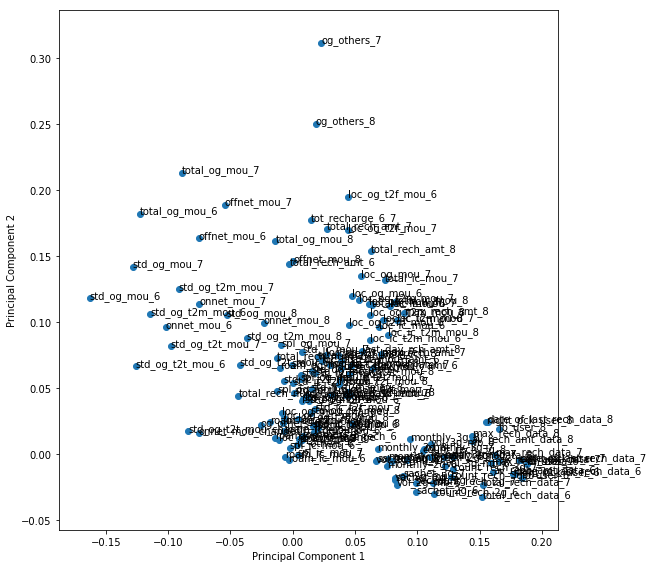

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pca_df.PC1, pca_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pca_df.Feature):
    plt.annotate(txt, (pca_df.PC1[i],pca_df.PC2[i]))
plt.tight_layout()
plt.show()

In [239]:
pca.explained_variance_ratio_

array([9.43901098e-02, 6.89174699e-02, 6.18983682e-02, 5.60929051e-02,
       4.75214256e-02, 3.71641020e-02, 3.41981687e-02, 3.37980763e-02,
       3.27026477e-02, 2.45550647e-02, 2.25274829e-02, 2.21053348e-02,
       2.00933293e-02, 1.73071628e-02, 1.71294677e-02, 1.67936552e-02,
       1.54966921e-02, 1.41761409e-02, 1.30875318e-02, 1.28872245e-02,
       1.23249278e-02, 1.21948738e-02, 1.16498857e-02, 1.12751958e-02,
       1.09953634e-02, 1.06549973e-02, 1.03176151e-02, 1.01475622e-02,
       9.91684513e-03, 9.74612160e-03, 8.35439060e-03, 7.63494848e-03,
       7.50567704e-03, 7.35154403e-03, 7.07815252e-03, 6.82303621e-03,
       6.52647207e-03, 6.24494590e-03, 5.95649690e-03, 5.90782847e-03,
       5.82220215e-03, 5.58762057e-03, 5.47077669e-03, 5.32347253e-03,
       5.15208559e-03, 4.97338756e-03, 4.76750655e-03, 4.73988533e-03,
       4.58616319e-03, 4.41860379e-03, 4.28581135e-03, 4.06278134e-03,
       3.82829190e-03, 3.74213890e-03, 3.62919366e-03, 3.55265593e-03,
      

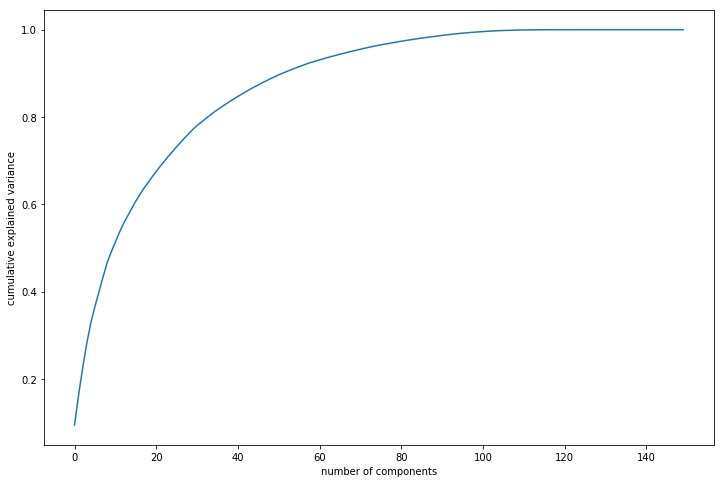

In [240]:
# Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## Let PCA select number of components based on a variance cutoff of 90%

In [241]:
pca_again = PCA(0.90)

In [242]:
df_train_pca2 = pca_again.fit_transform(X_train)
df_train_pca2.shape

(38206, 52)

In [243]:
pca_again.components_.shape

(52, 150)

### PCA selected 52 components
Number of components is 52 based on a variance cutoff of 90 %

In [244]:
# Create correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca2.transpose())

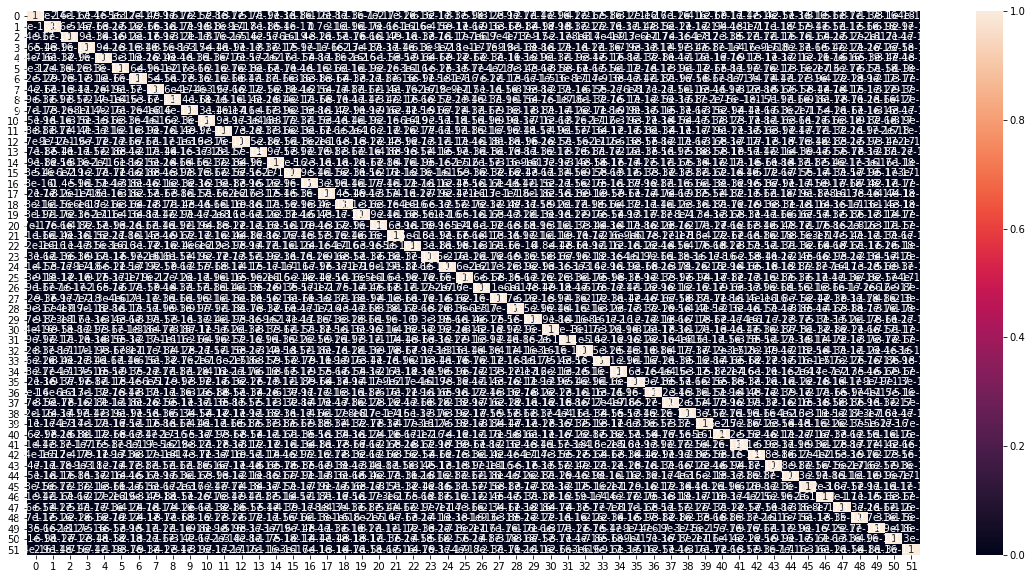

In [245]:
# Plot the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [246]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(), )
# we see that correlations are indeed very close to 0

max corr: 1.1250080745642148e-15 , min corr:  -1.0673350708780907e-15


# Apply Logistic regresssion to principal components

In [247]:
# Training the regression model
learner_pca2 = LogisticRegression()
model_pca2 = learner_pca2.fit(df_train_pca2, y_train)

In [248]:
df_test_pca2 = pca_again.transform(X_test)
df_test_pca2.shape

(16374, 52)

In [249]:
# Make predictions on the test data
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2f}".format(metrics.roc_auc_score(y_test, pred_probs_test2))

'0.89'

## Accuracy score is 89% on prediction

In [250]:
X_train_pca = pd.DataFrame(df_train_pca2)
X_test_pca = pd.DataFrame(df_test_pca2)
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,-2.418104,-1.012836,2.720005,2.449695,10.663591,1.078873,-3.738976,2.501433,-5.009025,-0.175920,...,0.903697,0.666430,-0.205095,0.416943,0.148874,-0.165327,-0.546308,0.069687,0.239309,0.105820
1,-2.835545,-1.770668,0.522575,0.763034,-0.322599,-0.756755,-1.070484,-1.151494,1.115950,0.488160,...,0.344773,0.198666,-0.341175,0.057145,-0.311202,-0.010607,0.364770,-0.253695,-0.468533,-0.369699
2,2.850904,-2.239111,-2.288806,3.965833,-2.210307,-0.320469,1.635716,2.030839,-2.270505,-0.415269,...,0.627846,0.437392,-0.521715,0.970177,-1.090437,-0.790427,-0.139562,-1.091429,0.082589,-0.499696
3,-2.946237,-1.996501,0.889613,0.437670,-0.246278,0.267823,1.233110,1.023901,-0.231964,-1.115957,...,-0.011024,0.120191,-0.133448,0.321529,-0.191477,0.155005,0.434746,0.364583,0.150890,-0.401658
4,6.510669,-2.618987,-3.550277,5.024300,-2.694783,-2.827818,-1.706786,2.219607,-2.737268,1.419016,...,0.596372,-0.729027,-0.264190,-0.067573,1.602626,-0.422790,0.447966,1.226956,-0.442409,2.611970


# Building other Models - Logistic Regression

In [251]:
# Logistic regression model
y_train= y_train.reset.index()
X_train_pca = Z_train_pca.reset.index()
logm1 = sm.GLM(y_train,(sm.add_constant(X_train_pca)), family = sm.families.Binomial())
logm1.fit().summary()

AttributeError: 'Series' object has no attribute 'reset'

In [ ]:
logreg = LogisticRegression()
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 5)             # running RFE with 5 variables as output
rfe = rfe.fit(X,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

In [ ]:
elim = X_train_pca.columns[~rfe.support_]
elim

In [ ]:
col = X_train_pca.columns[rfe.support_]
col 

In [ ]:
X_train_rfe = X_train_pca[col]
logsk = LogisticRegression(C=1e9)
#logsk.fit(X_train[col], y_train)
logsk.fit(X_train_rfe, y_train)

In [ ]:
#Comparing the model with StatsModels
#logm4 = sm.GLM(y_train,(sm.add_constant(X_train[col])), family = sm.families.Binomial())
logm2 = sm.GLM(y_train,(sm.add_constant(X_train_rfe)), family = sm.families.Binomial())
modres = logm2.fit()
logm2.fit().summary()

In [ ]:
X_test_pca[col].shape
#res = modres.predict(X_test

In [ ]:
# Predicted probabilities
y_pred = logsk.predict_proba(X_train_pca[col])
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()

In [ ]:
y_test.head()

In [ ]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

In [ ]:
y_test_df.index

In [ ]:
# Putting mobile number to index
y_test_df['mobile_number'] = y_test_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_Prob'})
# Rearranging the columns
y_pred_final = y_pred_final.reindex_axis(['mobile_number','churn','churn_Prob'], axis=1)
# Let's see the head of y_pred_final
y_pred_final.head()

In [ ]:
y_pred_1.head()

In [ ]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.5 else 0
y_pred_final['predicted'] = y_pred_final.churn_Prob.map( lambda x: 1 if x > 0.5 else 0)
# Let's see the head
y_pred_final.head()

In [ ]:
# Model Evaluation
from sklearn import metrics
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.predicted )
confusion

In [ ]:
#Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.predicted)

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds
draw_roc(y_pred_final.churn, y_pred_final.predicted)

In [ ]:
#draw_roc(y_pred_final.Churn, y_pred_final.predicted)
"{:2.2f}".format(metrics.roc_auc_score(y_pred_final.churn, y_pred_final.churn_Prob))

# We see Logistic Regression Model overall AUC score of 0.87

# Conclusion: